1. memoized / recursive over the target string
2. fast next target symbol prediction
3. lazy / avoids unnecessary materialization of DFA etc
4. factor Q and R into automata so that it terminates always
5. COMPREHESIBLE

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from transduction import examples, Precover, FSA, FST, EPSILON
from transduction.peekaboo_recursive import PeekabooState, Peekaboo
import transduction.peekaboo_recursive
from transduction.util import display_table
from transduction.foo import Analyze, visualization
from graphviz import Digraph

transduction.peekaboo_recursive.MAX_STEPS = 100

In [3]:
def compare(prev, curr):
    _prev = prev
    _curr = curr
    curr = curr.det#.trim()
    prev = prev.det#.trim()

    curr = FSA(
        start = curr.start,
        stop = curr.stop,
        arcs = [(i,x,j) for i in curr.states - _curr.det_universal_states for x,j in curr.arcs(i)],
    )
    prev = FSA(
        start = prev.start,
        stop = prev.stop,
        arcs = [(i,x,j) for i in prev.states - _prev.det_universal_states for x,j in prev.arcs(i)],
    )   

    removed_nodes = set()
    print('# nodes', colors.line(80))
    for i in sorted(prev.states - curr.states):   # remove
        print(colors.light.red % '├─ remove:', i)
        removed_nodes.add(i)
    for i in sorted(curr.states - prev.states):   # add
        print(colors.light.green % '├─ add:   ', i)
    for i in sorted(curr.states & prev.states):   # copy
        print(colors.light.yellow % '├─ copy:  ', i)

    prev_arcs = set(prev.arcs())
    curr_arcs = set(curr.arcs())
    
    print('# edges', colors.line(80))
    for (i,x,j) in sorted(prev_arcs - curr_arcs):
        if i in removed_nodes or j in removed_nodes: continue
        print(colors.light.red % '├─ remove:', (i,x,j))
    for (i,x,j) in sorted(curr_arcs - prev_arcs):
        print(colors.light.green % '├─ add:   ', (i,x,j))
    for (i,x,j) in sorted(curr_arcs & prev_arcs):
        print(colors.light.yellow % '├─ copy:  ', (i,x,j))


In [7]:
def rollout(fst, target):
    N = len(target)
    print(colors.bold % repr(''))
    prev = Precover(fst, '')
    display(prev)
    for n in range(1, N+1):
        print(colors.bold % repr(target[:n]))
        curr = Precover(fst, target[:n])
        compare(prev, curr)
        display(curr)
        prev = curr

### abc

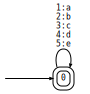

In [8]:
fst = examples.replace([('1', 'a'), ('2', 'b'), ('3', 'c'), ('4', 'd'), ('5', 'e')])
#Peekaboo(fst).graphviz('abc')
fst

''


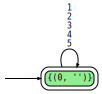

'a'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'a')}
├─ copy:   {(0, '')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, '')}, '1', {(0, 'a')})


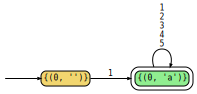

'ab'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'ab')}
├─ copy:   {(0, '')}
├─ copy:   {(0, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'a')}, '2', {(0, 'ab')})
├─ copy:   ({(0, '')}, '1', {(0, 'a')})


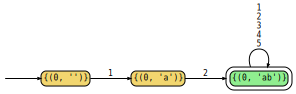

'abc'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ add:    {(0, 'abc')}
├─ copy:   {(0, '')}
├─ copy:   {(0, 'ab')}
├─ copy:   {(0, 'a')}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'ab')}, '3', {(0, 'abc')})
├─ copy:   ({(0, '')}, '1', {(0, 'a')})
├─ copy:   ({(0, 'a')}, '2', {(0, 'ab')})


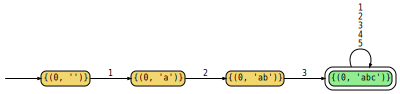

In [9]:
rollout(fst, 'abc')

### Parity

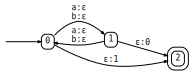

In [43]:
fst = examples.parity({'a', 'b'})
fst

'1'
''


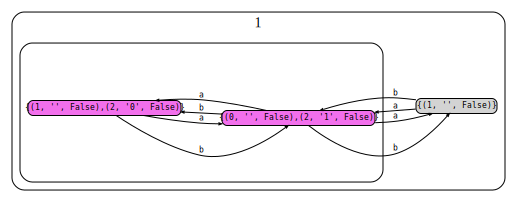

In [44]:
Peekaboo(fst).graphviz('1')

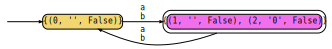

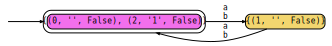

quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 1 <!-- start->0 --> start->0 <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 a b <!-- 1->0 --> 1->0 a b"


quotient,remainder
∅,"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 0 <!-- start->0 --> start->0 <!-- 1 --> 1 1 <!-- 0->1 --> 0->1 a b <!-- 1->0 --> 1->0 a b"


In [45]:
display(Precover(fst, '0'))
display(Precover(fst, '1'))
Precover(fst, '0').show_decomposition()
Precover(fst, '1').show_decomposition()

In [ ]:
#have = Peekaboo(fst)('')
#display_table([[y, *have[y]] for y in have])

### Samuel's machine

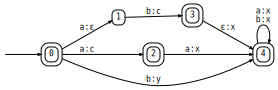

In [33]:
fst = examples.samuel_example()
#Peekaboo(fst).graphviz('cxx')
fst

''


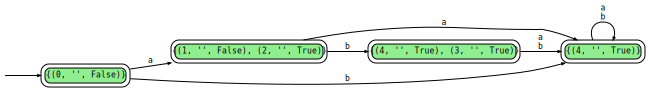

'c'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(1, '', False),(2, '', True)}
├─ remove: {(4, '', True)}
├─ remove: {(4, '', True),(3, '', True)}
├─ add:    {(1, '', False),(2, 'c', False)}
├─ add:    {(4, 'c', True)}
├─ add:    {(3, 'c', False),(4, 'c', True)}
├─ copy:   {(0, '', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, '', False)}, 'a', {(1, '', False),(2, 'c', False)})


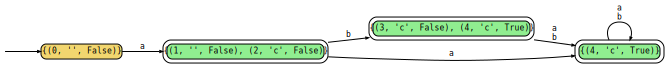

'cx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'c', True)}
├─ remove: {(3, 'c', False),(4, 'c', True)}
├─ add:    {(4, 'cx', False)}
├─ add:    {(3, 'c', False),(4, 'cx', False)}
├─ add:    {(4, 'cx', True)}
├─ copy:   {(0, '', False)}
├─ copy:   {(1, '', False),(2, 'c', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(1, '', False),(2, 'c', False)}, 'a', {(4, 'cx', False)})
├─ add:    ({(1, '', False),(2, 'c', False)}, 'b', {(3, 'c', False),(4, 'cx', False)})
├─ copy:   ({(0, '', False)}, 'a', {(1, '', False),(2, 'c', False)})


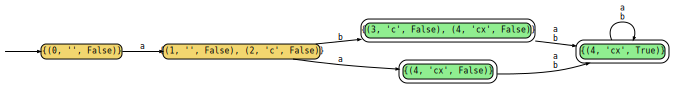

'cxx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'cx', True)}
├─ add:    {(4, 'cxx', False)}
├─ add:    {(4, 'cxx', True)}
├─ copy:   {(4, 'cx', False)}
├─ copy:   {(1, '', False),(2, 'c', False)}
├─ copy:   {(0, '', False)}
├─ copy:   {(3, 'c', False),(4, 'cx', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(4, 'cx', False)}, 'a', {(4, 'cxx', False)})
├─ add:    ({(4, 'cx', False)}, 'b', {(4, 'cxx', False)})
├─ add:    ({(3, 'c', False),(4, 'cx', False)}, 'a', {(4, 'cxx', False)})
├─ add:    ({(3, 'c', False),(4, 'cx', False)}, 'b', {(4, 'cxx', False)})
├─ copy:   ({(1, '', False),(2, 'c', False)}, 'a', {(4, 'cx', False)})
├─ copy:   ({(1, '', False),(2, 'c', False)}, 'b', {(3, 'c', False),(4, 'cx', False)})
├─ copy:   ({(0, '', False)}, 'a', {(1, '', False),(2, 'c', False)})


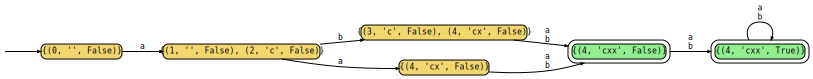

'cxxx'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, 'cxx', True)}
├─ add:    {(4, 'cxxx', True)}
├─ add:    {(4, 'cxxx', False)}
├─ copy:   {(1, '', False),(2, 'c', False)}
├─ copy:   {(4, 'cxx', False)}
├─ copy:   {(3, 'c', False),(4, 'cx', False)}
├─ copy:   {(0, '', False)}
├─ copy:   {(4, 'cx', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(4, 'cxx', False)}, 'a', {(4, 'cxxx', False)})
├─ add:    ({(4, 'cxx', False)}, 'b', {(4, 'cxxx', False)})
├─ copy:   ({(1, '', False),(2, 'c', False)}, 'a', {(4, 'cx', False)})
├─ copy:   ({(4, 'cx', False)}, 'a', {(4, 'cxx', False)})
├─ copy:   ({(4, 'cx', False)}, 'b', {(4, 'cxx', False)})
├─ copy:   ({(3, 'c', False),(4, 'cx', False)}, 'a', {(4, 'cxx', False)})
├─ copy:   ({(3, 'c', False),(4, 'cx', False)}, 'b', {(4, 'cxx', False)})
├─ copy:   ({(0, '', False)}, 'a', {(1, '', False),(2, 'c', False)})
├─ copy:   ({(1, ''

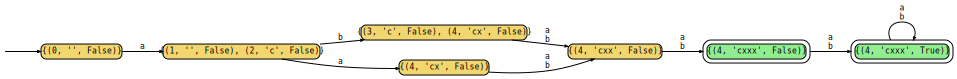

In [34]:
rollout(fst, 'cxxx')

'cxxx'
'cxx'
'cx'
'c'
''


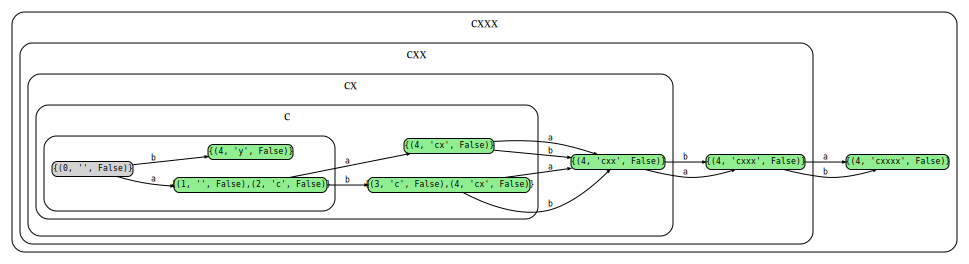

In [35]:
Peekaboo(fst).graphviz('cxxx')

'1'
''


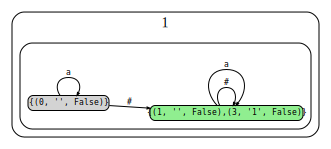

In [47]:
fst = examples.infinite_quotient()
Peekaboo(fst, max_steps=100).graphviz('1')

In [49]:
Precover(fst, '1').show_decomposition()

quotient,remainder
"<?xml version=""1.0"" encoding=""UTF-8"" standalone=""no""?> <!DOCTYPE svg PUBLIC ""-//W3C//DTD SVG 1.1//EN"" ""http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd""> <!-- Generated by graphviz version 2.43.0 (0) --> <!-- Title: %3 Pages: 1 --> %3 <!-- start --> start <!-- 0 --> 0 2 <!-- start->0 --> start->0 <!-- 0->0 --> 0->0 a <!-- 1 --> 1 0 <!-- 0->1 --> 0->1 #",∅


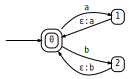

In [37]:
fst = examples.duplicate('ab').renumber
fst

'aabba'
'aabb'
'aab'
'aa'
'a'
''


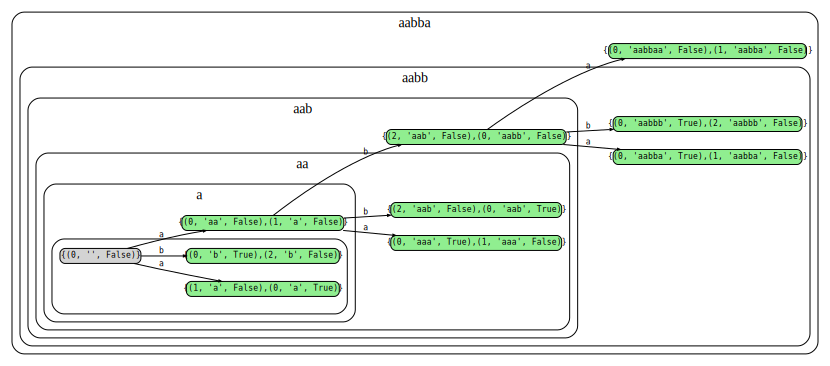

In [42]:
Peekaboo(fst).graphviz('aabba')

In [ ]:
from transduction import FST, EPSILON
def duplicate(V, K):
    "Duplicate (by K > 1) each symbol in the input string, e.g., `abc -> a^K b^K c^K`."
    assert K > 1
    dup = FST()
    dup.add_I(0)
    for b in V:
        dup.add_arc(0, b, b, (0, b))
        for k in range(K-2):
            dup.add_arc((k, b), EPSILON, b, (k+1, b))
        dup.add_arc((K-2, b), EPSILON, b, 0)
    dup.add_F(0)
    return dup.renumber

duplicate({'a', 'b'}, 3)

In [ ]:
#fst = examples.duplicate('ab')
#show(fst, 'aaaabbbba')

In [ ]:
fst = duplicate({'a', 'b'}, 4)
Peekaboo(fst).graphviz('aaaabbbba')

In [ ]:
Precover(fst, 'aaaabbbba').show_decomposition()

### Triples of doom

In [24]:
def poison(V, K):   # k-tuples of doom
    assert K > 1
    dup = FST()
    dup.add_I(0)
    for b in V:
        dup.add_arc(0, b, b, (0, b))
        for k in range(K-2):
            dup.add_arc((k, b), b, b, (k+1, b))
        dup.add_arc((K-2, b), EPSILON, EPSILON, 0)
    dup.add_F(0)
    return dup.renumber
#p = poison({'a', 'b'}, 3)
#display(p)

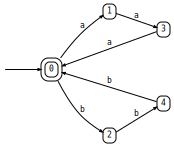

In [25]:
p = examples.triplets_of_doom()
p

In [26]:
list(p.relation(5))

[('', ''), ('aaa', 'aaa'), ('bbb', 'bbb')]

In [27]:
#p = examples.weird_copy()
#Peekaboo(p).graphviz('aaa')

''


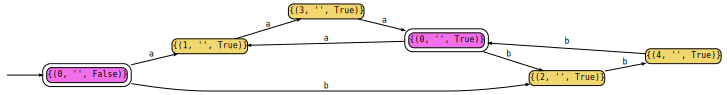

'a'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(4, '', True)}
├─ remove: {(1, '', True)}
├─ remove: {(3, '', True)}
├─ remove: {(2, '', True)}
├─ remove: {(0, '', True)}
├─ add:    {(1, 'a', True)}
├─ add:    {(0, 'a', True)}
├─ add:    {(1, 'a', False)}
├─ add:    {(4, 'a', True)}
├─ add:    {(3, 'a', True)}
├─ add:    {(2, 'a', True)}
├─ copy:   {(0, '', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(1, 'a', False)}, 'a', {(3, 'a', True)})
├─ add:    ({(4, 'a', True)}, 'b', {(0, 'a', True)})
├─ add:    ({(1, 'a', True)}, 'a', {(3, 'a', True)})
├─ add:    ({(3, 'a', True)}, 'a', {(0, 'a', True)})
├─ add:    ({(0, '', False)}, 'a', {(1, 'a', False)})
├─ add:    ({(0, 'a', True)}, 'a', {(1, 'a', True)})
├─ add:    ({(0, 'a', True)}, 'b', {(2, 'a', True)})
├─ add:    ({(2, 'a', True)}, 'b', {(4, 'a', True)})


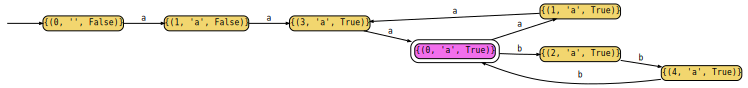

'aa'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(1, 'a', True)}
├─ remove: {(0, 'a', True)}
├─ remove: {(4, 'a', True)}
├─ remove: {(3, 'a', True)}
├─ remove: {(2, 'a', True)}
├─ add:    {(2, 'aa', True)}
├─ add:    {(4, 'aa', True)}
├─ add:    {(1, 'aa', True)}
├─ add:    {(3, 'aa', False)}
├─ add:    {(0, 'aa', True)}
├─ add:    {(3, 'aa', True)}
├─ copy:   {(0, '', False)}
├─ copy:   {(1, 'a', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(2, 'aa', True)}, 'b', {(4, 'aa', True)})
├─ add:    ({(1, 'a', False)}, 'a', {(3, 'aa', False)})
├─ add:    ({(1, 'aa', True)}, 'a', {(3, 'aa', True)})
├─ add:    ({(3, 'aa', False)}, 'a', {(0, 'aa', True)})
├─ add:    ({(3, 'aa', True)}, 'a', {(0, 'aa', True)})
├─ add:    ({(0, 'aa', True)}, 'b', {(2, 'aa', True)})
├─ add:    ({(4, 'aa', True)}, 'b', {(0, 'aa', True)})
├─ add:    ({(0, 'aa', True)}, 'a', {(1, 'aa', True)})
├─ 

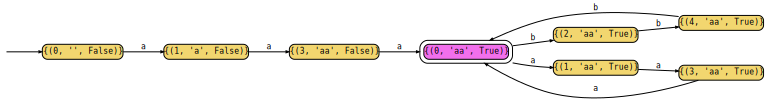

'aaa'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(2, 'aa', True)}
├─ remove: {(4, 'aa', True)}
├─ remove: {(1, 'aa', True)}
├─ remove: {(0, 'aa', True)}
├─ remove: {(3, 'aa', True)}
├─ add:    {(1, 'aaa', True)}
├─ add:    {(2, 'aaa', True)}
├─ add:    {(0, 'aaa', True)}
├─ add:    {(3, 'aaa', True)}
├─ add:    {(0, 'aaa', False)}
├─ add:    {(4, 'aaa', True)}
├─ copy:   {(3, 'aa', False)}
├─ copy:   {(0, '', False)}
├─ copy:   {(1, 'a', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(0, 'aaa', True)}, 'a', {(1, 'aaa', True)})
├─ add:    ({(0, 'aaa', False)}, 'b', {(2, 'aaa', True)})
├─ add:    ({(1, 'aaa', True)}, 'a', {(3, 'aaa', True)})
├─ add:    ({(0, 'aaa', False)}, 'a', {(1, 'aaa', True)})
├─ add:    ({(3, 'aaa', True)}, 'a', {(0, 'aaa', True)})
├─ add:    ({(2, 'aaa', True)}, 'b', {(4, 'aaa', True)})
├─ add:    ({(3, 'aa', False)}, 'a', {(0, 'aaa', False)})
├

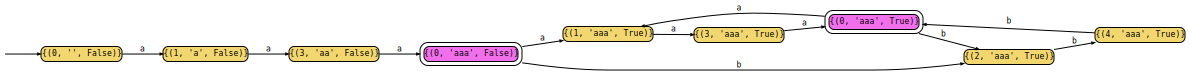

'aaab'
# nodes ────────────────────────────────────────────────────────────────────────────────
├─ remove: {(1, 'aaa', True)}
├─ remove: {(2, 'aaa', True)}
├─ remove: {(0, 'aaa', True)}
├─ remove: {(3, 'aaa', True)}
├─ remove: {(4, 'aaa', True)}
├─ add:    {(2, 'aaab', False)}
├─ add:    {(1, 'aaab', True)}
├─ add:    {(2, 'aaab', True)}
├─ add:    {(3, 'aaab', True)}
├─ add:    {(4, 'aaab', True)}
├─ add:    {(0, 'aaab', True)}
├─ copy:   {(3, 'aa', False)}
├─ copy:   {(0, '', False)}
├─ copy:   {(0, 'aaa', False)}
├─ copy:   {(1, 'a', False)}
# edges ────────────────────────────────────────────────────────────────────────────────
├─ add:    ({(2, 'aaab', False)}, 'b', {(4, 'aaab', True)})
├─ add:    ({(1, 'aaab', True)}, 'a', {(3, 'aaab', True)})
├─ add:    ({(0, 'aaab', True)}, 'a', {(1, 'aaab', True)})
├─ add:    ({(3, 'aaab', True)}, 'a', {(0, 'aaab', True)})
├─ add:    ({(2, 'aaab', True)}, 'b', {(4, 'aaab', True)})
├─ add:    ({(0, 'aaa', False)}, 'b', {(2, 'aaab', False)})
├─ a

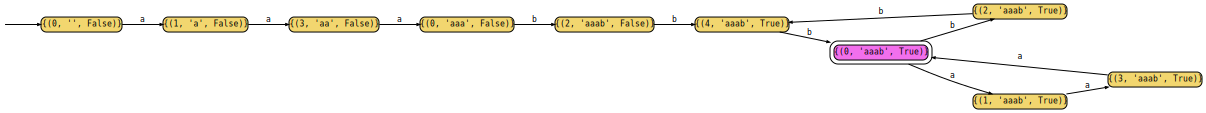

In [28]:
rollout(p, 'aaab')

'aaab'
'aaa'
'aa'
'a'
''


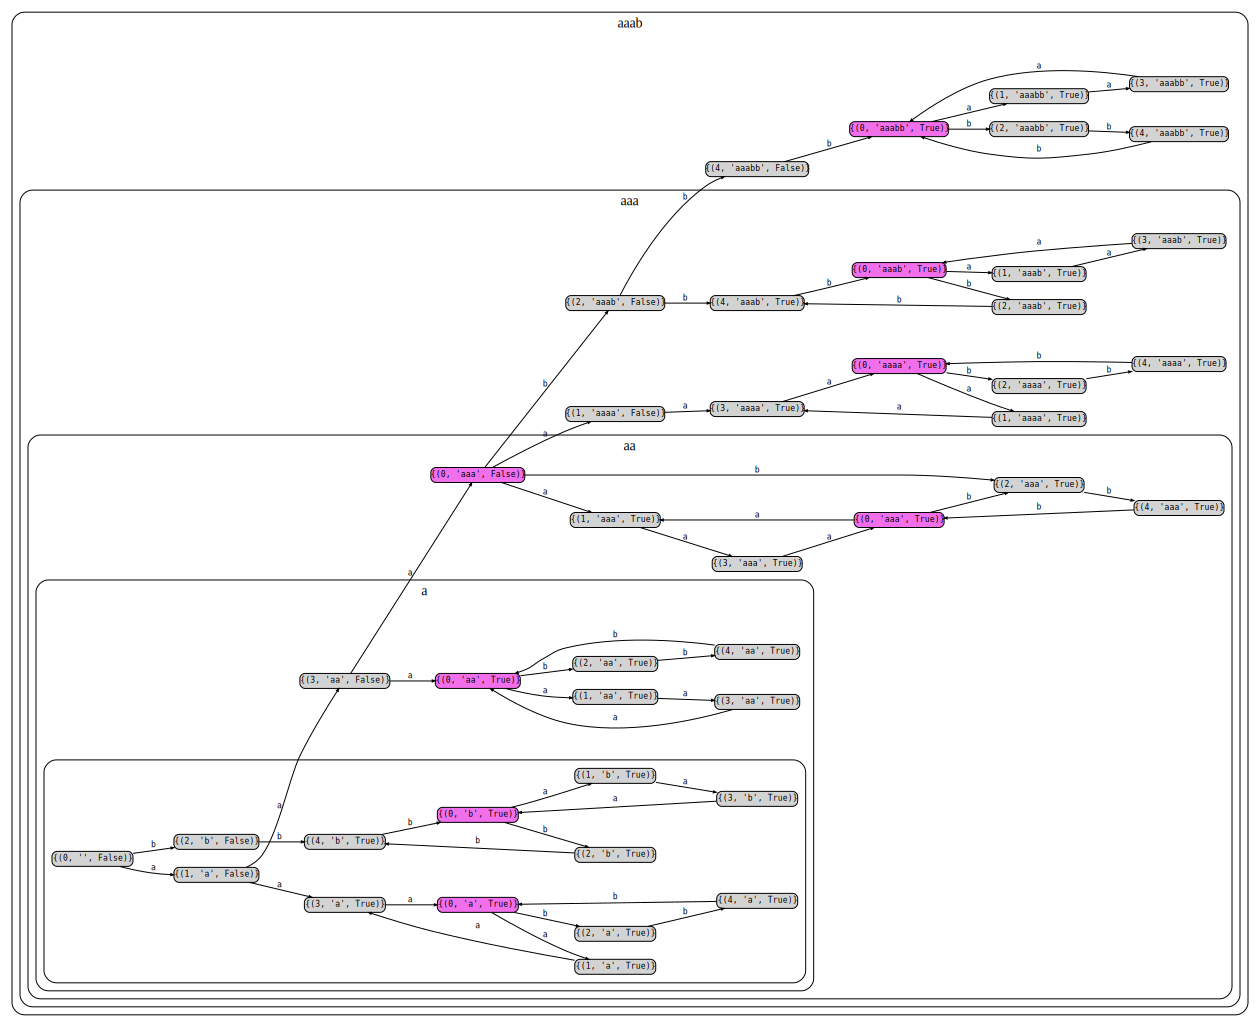

In [32]:
Peekaboo(p).graphviz('aaab')

In [ ]:
# import transduction.peekaboo
# import transduction.peekaboo_recursive
# fst = examples.newspeak2()
# pp = transduction.peekaboo.Peekaboo(p, max_steps=50)
# target = ''
# have = pp(target, return_strings=False)
# want = {y: Precover(p, target + y).decomposition for y in pp.target_alphabet}
# for y in pp.target_alphabet:
#     print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))
# #transduction.peekaboo_recursive.assert_equal_decomp_map(have, want)

In [ ]:
#import transduction.peekaboo_recursive
#class BufferedRelevance(transduction.peekaboo_recursive.BufferedRelevance):
#    def is_final(self, state): 
#        (i, ys) = state
#        return self.fst.is_final(i) and ys.startswith(self.target)

In [ ]:
#dfa = BufferedRelevance(p, 'a').det()
#dfa.materialize(10)

In [ ]:
#for x,y in p.relation(5):
#    print([x,y])

In [ ]:
#p.renumber.dump()

In [ ]:
# from transduction.lazy_recursive import LazyRecursive
# tmp = LazyRecursive(p, max_steps=100)
# tmp('a')

In [ ]:
#Precover(p, 'a')

In [ ]:
#from transduction.lazy_recursive import LazyRecursive
#tmp = LazyRecursive(p, max_steps=100)
#tmp('ab')

In [ ]:
# class BufferedRelevance(transduction.peekaboo_recursive.BufferedRelevance):
#     def is_final(self, state):
#         i, ys = state
#         return self.fst.is_final(i) and ys.startswith(self.target) #and len(ys) == len(self.target) + 1 

In [ ]:
# BufferedRelevance(p, 'a').materialize(10)

In [ ]:
# from transduction import Precover, EagerNonrecursive
# from transduction.vibes import visualize_automaton
# fst = examples.newspeak2()
# p = Peekaboo(fst)
# target = ''
# have = p(target)
# tmp = EagerNonrecursive(fst)
# want = {y: tmp(target + y) for y in tmp.target_alphabet}
# assert have['b'].quotient.equal(want['b'].quotient)
# #assert_equal_decomp_map(have, want)

In [ ]:
#for y in fst.B - {EPSILON}:
#    print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))

In [ ]:
#have['b'].quotient.min()

In [ ]:
#FSA.from_strings(want['b'].quotient).min()

In [ ]:
#visualize_automaton(FSA.from_strings(want['b'].quotient).min())

In [ ]:
#visualize_automaton(have['b'].quotient.min())

In [ ]:
# import transduction.peekaboo
# import transduction.peekaboo_recursive
# fst = examples.newspeak2()
# p = transduction.peekaboo.Peekaboo(fst)
# target = ''
# have = p(target, return_strings=False)
# tmp = EagerNonrecursive(fst)
# want = {y: tmp(target + y) for y in tmp.target_alphabet}
# #for y in fst.B - {EPSILON}:
# #    print(colors.mark(have[y].quotient.equal(want[y].quotient)), colors.mark(have[y].remainder.equal(want[y].remainder)), repr(y))
# transduction.peekaboo_recursive.assert_equal_decomp_map(have, want)

In [ ]:
fst = examples.small()
fst

In [ ]:
Peekaboo(fst, max_steps=100).check('')

In [ ]:
Peekaboo(fst, max_steps=100).graphviz('xab')

In [ ]:
rollout(fst, 'xab')

In [ ]:
Precover(fst, '')

In [ ]:
Precover(fst, 'x')

In [ ]:
Precover(fst, 'x').show_decomposition()

In [ ]:
# def graphviz(fst, target):
#     from graphviz import Digraph
#     from transduction.lazy_nonrecursive import LazyPrecoverNFA

#     # TODO: [2025-12-06 Sat] The funny thing about this picture is that the
#     # plates are technical for the wrong target string.  specifically, they are
#     # the precover of the next-target symbol extension of the target target
#     # context thus, we have in each plate the *union* of the precovers

#     # TODO: use the integerizer here so that nodes are not improperly
#     # equated with thier string representations.
#     from arsenal import Integerizer
#     m = Integerizer()

#     source_alphabet = fst.A - {EPSILON}

#     dups = set()

#     def helper(target, outer):
#         with outer.subgraph(name="cluster") as inner:
#             inner.attr(label=target or 'ε',
#                        style='rounded, filled', color='black', fillcolor='#e0ffe0')

#             if target == '':
#                 old_arcs = set()            
#                 prev_universal = set()
#             else:
#                 prev = helper(target[:-1], inner)
#                 prev_dfa = LazyPrecoverNFA(fst, target[:-1]).det()
#                 old_arcs = {(i,x,j) for i in prev.states for x, j in prev.arcs(i)}
#                 prev_universal = {i for i in prev.states if prev_dfa.accepts_universal(i, source_alphabet)}

#             curr_dfa = LazyPrecoverNFA(fst, target).det()
#             curr = curr_dfa.materialize()
#             new_arcs = {(i,x,j) for i in curr.states for x, j in curr.arcs(i)}
            
#             curr_universal = {i for i in curr.states if curr_dfa.accepts_universal(i, source_alphabet)}
#             curr_remainder = {i for i in curr.states if curr_dfa.is_final(i)} - curr_universal

#             print(repr(target))
            
#             for (i,x,j) in old_arcs - new_arcs:
#                 if i in prev_universal: continue
#                 print(colors.light.red % 'remove:', (i,x,j))
#             for (i,x,j) in new_arcs - old_arcs:
#                 print(colors.light.green % 'added: ', (i,x,j))
#             for (i,x,j) in new_arcs & old_arcs:
#                 if i in prev_universal:
#                     continue
#                 print('keep:  ', (i,x,j))

#             if target:            
#                 for i in prev.states - curr.states:   # removed
#                     pass
#                 for i in curr.states & prev.states:   # kept
#                     if i in curr_universal:
#                         print('===> need to copy old node:', i)
#                     elif i in curr_remainder:
#                         print('===> need to copy old node:', i)                    
#                 for i in curr.states - prev.states:   # addded
#                     pass

#             for i in curr.states:
#                 if i in curr_universal:
#                     inner.node(str(i), fillcolor='red')
#                     continue
#                 elif i in curr_remainder:
#                     inner.node(str(i), fillcolor='magenta')
                
#                 if not i: continue
#                 for x, j in curr.arcs(i):
#                     if not j: continue
#                     if (i,x,j) in dups:
#                         continue
#                     dups.add((i,x,j))
#                     inner.edge(str(i), str(j), label=x)

#             return curr

#     dot = Digraph(
#         graph_attr=dict(rankdir='LR'),
#         node_attr=dict(
#             fontname='Monospace',
#             fontsize='8',
#             height='.05',
#             width='.05',
#             margin="0.055,0.042",
#             shape='box',
#             style='rounded, filled',
#         ),
#         edge_attr=dict(
#             arrowsize='0.3',
#             fontname='Monospace',
#             fontsize='8'
#         ),
#     )

#     with dot.subgraph(name='outer') as outer:
#         helper(target, outer)

#     return dot


In [ ]:
# graphviz(fst, 'xabab')

In [ ]:
fst = examples.lookahead()
display(fst)
P = Precover(fst, 'x')
display(P)
P.show_decomposition(minimize=False)

In [ ]:
Peekaboo(fst).graphviz('xab')

In [ ]:
Peekaboo(fst).graphviz('xx')

In [ ]:
fst = examples.samuel_example()
fst

In [ ]:
Target = 'cxx'

In [ ]:
visualization(fst, Target)